Epoch 0, Loss: 1.4397485256195068
Epoch 1000, Loss: 0.008850004523992538
Epoch 2000, Loss: 0.004402317572385073
Epoch 3000, Loss: 0.0029766736552119255
Epoch 4000, Loss: 0.002468397840857506
Epoch 5000, Loss: 0.0020934552885591984
Epoch 6000, Loss: 0.0018869796767830849
Epoch 7000, Loss: 0.0014497739030048251
Epoch 8000, Loss: 0.001205755746923387
Epoch 9000, Loss: 0.0011330230627208948


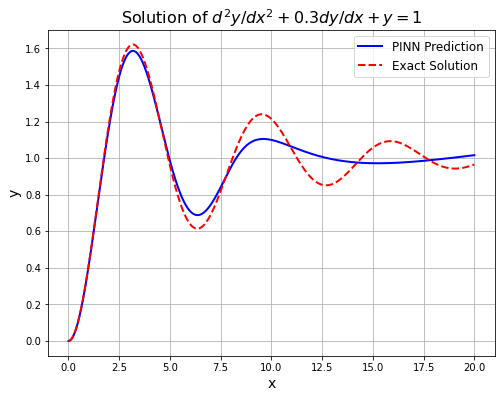

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)  # Input layer: 1 neuron (time t)
        self.fc2 = nn.Linear(20, 20) # Hidden layer 1: 20 neurons
        self.fc3 = nn.Linear(20, 20) # Hidden layer 2: 20 neurons
        self.fc4 = nn.Linear(20, 1)  # Output layer: 1 neuron (solution y)
        self.activation = torch.tanh # Activation function: tanh

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the loss function computation process
def compute_loss(model, t_domain, t_initial):
    # Compute the differential equation residual
    t_domain.requires_grad = True
    y = model(t_domain)
    dy_dt = torch.autograd.grad(y, t_domain, 
                               grad_outputs=torch.ones_like(y),
                               create_graph=True)[0]          # First derivative
    d2y_dt2 = torch.autograd.grad(dy_dt, t_domain, 
                                 grad_outputs=torch.ones_like(dy_dt),
                                 create_graph=True)[0]        # Second derivative
    equation = d2y_dt2 + 0.3 * dy_dt + y - 1                 # Differential equation residual
    loss_equation = torch.mean(equation**2)                  # MSE of equation residual
    
    # Compute the initial condition loss
    y_initial = model(t_initial)
    dy_initial = torch.autograd.grad(y_initial, t_initial,
                                    grad_outputs=torch.ones_like(y_initial),
                                    create_graph=True)[0]     # First derivative at t=0
    loss_initial_y = torch.mean((y_initial - 0)**2)          # y(0)=0
    loss_initial_dy = torch.mean((dy_initial - 0)**2)        # y'(0)=0
    
    # Total loss (weighted sum)
    total_loss = loss_equation + loss_initial_y + loss_initial_dy
    return total_loss

# Parameter settings
T = 20.0            # Time domain range [0, T]
num_epochs = 10000  # Number of training epochs
num_domain = 1000   # Number of sampled points per epoch

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Generate random domain sample points (shape: [num_domain, 1])
    t_domain = torch.rand(num_domain, 1) * T
    t_domain.requires_grad = True
    
    # Initial condition point (fixed at t=0)
    t_initial = torch.tensor([[0.0]], dtype=torch.float32)
    t_initial.requires_grad = True
    
    # Compute loss and backpropagate
    loss = compute_loss(model, t_domain, t_initial)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate test data and predict results
t_test = torch.linspace(0, T, 300).reshape(-1, 1)
y_pred = model(t_test).detach().numpy()

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Generate test points
x_test = torch.linspace(0, 20, 1000).view(-1, 1)

# Compute the exact solution
def exact_solution(t):
    return np.exp(-0.15 * t) * (-np.cos(0.9899 * t) - 0.1515 * np.sin(0.9899 * t)) + 1

x_np = x_test.numpy().flatten()
y_exact = exact_solution(x_np)

# Plot the solution curves
with torch.no_grad():
    y_pred = model(x_test).numpy()

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_np, y_pred, 'b-', linewidth=2, label='PINN Prediction')
plt.plot(x_np, y_exact, 'r--', linewidth=2, label='Exact Solution')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=12)
plt.title('Solution of $d^2y/dx^2 + 0.3dy/dx+y=1$', fontsize=16)
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9144934377400062, mae_pinn: 0.06579603999853134, rmse_pinn: 0.08063843846321106, inf_norm_pinn: 0.16323202848434448


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_07.csv', index=False)
print(" pinn_07.csv")

数据已保存至 pinn_07.csv
